In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# click data read from csv
prof_click_datas = pd.read_csv('./trajectory/trajectory_prof.csv')
prof2_datas = pd.read_csv('./trajectory/prof2.csv')
my_click_datas = pd.read_csv('./trajectory/trajectory_my_agent.csv')
opponent_click_datas = pd.read_csv('./trajectory/trajectory_opponent.csv')
improved_decision_making_datas = pd.read_csv('./trajectory/trajectory_improved_Decision_making.csv')
improved_motor_execution_datas = pd.read_csv('./trajectory/trajectory_improved_Motor_execution.csv')

In [3]:
# click data로부터 target radius, target speed binnig 을 위한 data 추출
def extract_data(click_datas, do_print):
    click_datas.head()

    click_datas.shape

    user0 = click_datas[click_datas.user == 0]

    user0 = user0[user0.click_action == 1]
    user0 = user0.reset_index(drop=True)
    user0


    radius_avg = []
    fail_rate_r = []
    complete_time_r = []
    radius_start = 0.009
    radius_range = 0.001

    for i in range(15):
        radius = user0
        radius = radius[radius.target_radius >= radius_start]
        radius = radius[radius.target_radius < radius_start + radius_range]
        radius = radius.reset_index(drop=True)

        radius_avg.append(radius['target_radius'].mean())
        fail_rate_r.append(1.0 - radius['click_success'].mean())
        complete_time_r.append(radius['time'].mean())

        print('radius( {0:0.3f} ~ {1:0.3f} ) : average: {2:0.4f}  fail_rate: {3:0.4f}%  completion_time_mean: {4:0.4f}s'.format(radius_start, radius_start + radius_range, radius_avg[i] ,fail_rate_r[i], complete_time_r[i]))
        radius_start += radius_range
    
    corr_radius = pd.DataFrame({'radius_avg': radius_avg,
                                 'fail_rate': fail_rate_r,
                                   'complete_time': complete_time_r})


    print('\n------------------------------------------------------------------------------------------------------\n')

    speed_avg = []
    fail_rate_s = []
    complete_time_s = []
    speed_start = 0.00
    speed_range = 0.05

    for i in range(10):
        speed = user0
        speed = speed[speed.target_speed >= speed_start]
        speed = speed[speed.target_speed < speed_start + speed_range]
        speed = speed.reset_index(drop=True)

        speed_avg.append(speed['target_speed'].mean())
        fail_rate_s.append(1.0 - speed['click_success'].mean())
        complete_time_s.append(speed['time'].mean())

        print('speed( {0:0.3f} ~ {1:0.3f} ) : average: {2:0.4f}  fail_rate: {3:0.4f}%  completion_time_mean: {4:0.4f}s'.format(speed_start, speed_start + speed_range, speed_avg[i] ,fail_rate_s[i], complete_time_s[i]))
        speed_start += speed_range

    corr_speed = pd.DataFrame({'speed_avg': speed_avg,
                                 'fail_rate': fail_rate_s,
                                  'complete_time': complete_time_s})
    corr_speed
    
    if do_print == True:
        corr_radius.plot(kind='scatter', x='radius_avg', y='fail_rate')
        fit_weight = np.polyfit(corr_radius['radius_avg'], corr_radius['fail_rate'], 1) # 'avg' 컬럼을 x값으로, 5 컬럼을 y값으로 하여 1차식으로 피팅한다.
        trend_f = np.poly1d(fit_weight)

        plt.plot(corr_radius['radius_avg'], trend_f(corr_radius['radius_avg']),"r-")
        plt.title("y={:.6f}x+({:.6f})".format(fit_weight[0], fit_weight[1]))
        plt.show()
        
        corr_speed.plot(kind='scatter', x='speed_avg', y='fail_rate')
        fit_weight = np.polyfit(corr_speed['speed_avg'], corr_speed['fail_rate'], 1) # 'avg' 컬럼을 x값으로, 5 컬럼을 y값으로 하여 1차식으로 피팅한다.
        trend_f = np.poly1d(fit_weight)

        plt.plot(corr_speed['speed_avg'], trend_f(corr_speed['speed_avg']),"r-")
        plt.title("y={:.6f}x+({:.6f})".format(fit_weight[0], fit_weight[1]))
        plt.show()
    
    corr = {'radius': corr_radius, 'speed': corr_speed}
    return corr

In [4]:
# binning 된 data들로부터 상관관계 그래프 출력
def print_corr_graph(first_str, first_corr, second_str, second_corr):
    
    corr_str = "R = {:.4f}\n( y={:.2f}x + {:.2f} )"
    binning_str = ["Target Radius Binning", "Target Speed Binning"]
    
    for i, binnig in enumerate(['radius', 'speed']):
        corr_complete_time = pd.DataFrame({first_str: first_corr[binnig]['complete_time'],
                                       second_str: second_corr[binnig]['complete_time']})
        time_df = corr_complete_time.corr()
        print(time_df)
        time_r = time_df[first_str][second_str]

        ct_fit_weight = np.polyfit(first_corr[binnig]['complete_time'], second_corr[binnig]['complete_time'], 1)
        ct_trend_f = np.poly1d(ct_fit_weight)

        corr_fail_rate = pd.DataFrame({first_str: first_corr[binnig]['fail_rate'],
                                       second_str: second_corr[binnig]['fail_rate']})
        fali_rate_df = corr_fail_rate.corr()
        print(fali_rate_df)
        fali_rate_r = fali_rate_df[first_str][second_str]

        fr_fit_weight = np.polyfit(first_corr[binnig]['fail_rate'], second_corr[binnig]['fail_rate'], 1)
        fr_trend_f = np.poly1d(fr_fit_weight)
        
        plt.rc('font', size=12)
        plt.figure(figsize=(5,5))
        plt.plot([0.0, 1.2], [0.0, 1.2], "lightgray")
        plt.plot(first_corr[binnig]['fail_rate'], fr_trend_f(first_corr[binnig]['fail_rate']), label='fail rate')
        plt.plot(first_corr[binnig]['complete_time'], ct_trend_f(first_corr[binnig]['complete_time']), label='trial completion time')
        plt.text(0.35, 0.15, corr_str.format(fali_rate_r, fr_fit_weight[0], fr_fit_weight[1]))
        plt.text(0.18, 0.8, corr_str.format(time_r, ct_fit_weight[0], ct_fit_weight[1]))
        plt.title(binning_str[i])
        plt.scatter(first_corr[binnig]['fail_rate'], fr_trend_f(first_corr[binnig]['fail_rate']), color='cornflowerblue')
        plt.scatter(first_corr[binnig]['complete_time'], ct_trend_f(first_corr[binnig]['complete_time']), color='darksalmon')
        plt.grid()
        plt.axis('square')
        plt.axis([0.0, 1.2, 0.0, 1.2])
        plt.xlabel(first_str)
        plt.ylabel(second_str)
        plt.legend()
        plt.show()
        plt.clf()
    
    return

radius( 0.009 ~ 0.010 ) : average: 0.0098  fail_rate: 0.5252%  completion_time_mean: 1.0086s
radius( 0.010 ~ 0.011 ) : average: 0.0105  fail_rate: 0.4851%  completion_time_mean: 0.9954s
radius( 0.011 ~ 0.012 ) : average: 0.0115  fail_rate: 0.4501%  completion_time_mean: 0.9653s
radius( 0.012 ~ 0.013 ) : average: 0.0125  fail_rate: 0.4101%  completion_time_mean: 0.9119s
radius( 0.013 ~ 0.014 ) : average: 0.0135  fail_rate: 0.3702%  completion_time_mean: 0.8885s
radius( 0.014 ~ 0.015 ) : average: 0.0145  fail_rate: 0.3194%  completion_time_mean: 0.8355s
radius( 0.015 ~ 0.016 ) : average: 0.0155  fail_rate: 0.2959%  completion_time_mean: 0.8145s
radius( 0.016 ~ 0.017 ) : average: 0.0165  fail_rate: 0.3030%  completion_time_mean: 0.7860s
radius( 0.017 ~ 0.018 ) : average: 0.0175  fail_rate: 0.2635%  completion_time_mean: 0.7791s
radius( 0.018 ~ 0.019 ) : average: 0.0185  fail_rate: 0.2357%  completion_time_mean: 0.7821s
radius( 0.019 ~ 0.020 ) : average: 0.0195  fail_rate: 0.2084%  complet

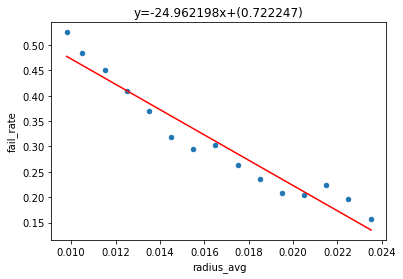

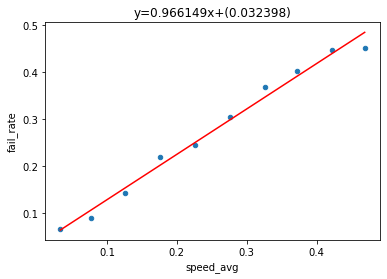

radius( 0.009 ~ 0.010 ) : average: 0.0098  fail_rate: 0.5524%  completion_time_mean: 1.1128s
radius( 0.010 ~ 0.011 ) : average: 0.0105  fail_rate: 0.5041%  completion_time_mean: 1.0729s
radius( 0.011 ~ 0.012 ) : average: 0.0115  fail_rate: 0.4518%  completion_time_mean: 1.0130s
radius( 0.012 ~ 0.013 ) : average: 0.0125  fail_rate: 0.4467%  completion_time_mean: 0.9759s
radius( 0.013 ~ 0.014 ) : average: 0.0135  fail_rate: 0.4028%  completion_time_mean: 0.9586s
radius( 0.014 ~ 0.015 ) : average: 0.0145  fail_rate: 0.3628%  completion_time_mean: 0.9016s
radius( 0.015 ~ 0.016 ) : average: 0.0155  fail_rate: 0.3343%  completion_time_mean: 0.8607s
radius( 0.016 ~ 0.017 ) : average: 0.0165  fail_rate: 0.3025%  completion_time_mean: 0.8353s
radius( 0.017 ~ 0.018 ) : average: 0.0175  fail_rate: 0.3032%  completion_time_mean: 0.8061s
radius( 0.018 ~ 0.019 ) : average: 0.0185  fail_rate: 0.2770%  completion_time_mean: 0.7855s
radius( 0.019 ~ 0.020 ) : average: 0.0195  fail_rate: 0.2452%  complet

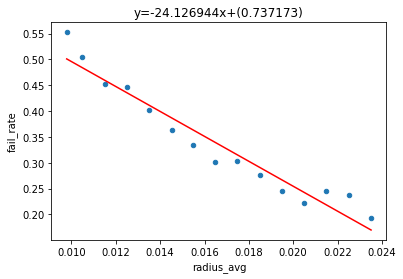

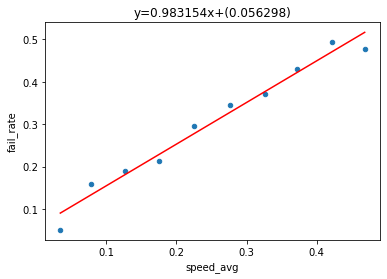

In [5]:
prof_corr = extract_data(prof_click_datas, True)
prof2_corr = extract_data(prof2_datas, True)

radius( 0.009 ~ 0.010 ) : average: 0.0098  fail_rate: 0.5324%  completion_time_mean: 0.9414s
radius( 0.010 ~ 0.011 ) : average: 0.0105  fail_rate: 0.4286%  completion_time_mean: 0.8964s
radius( 0.011 ~ 0.012 ) : average: 0.0115  fail_rate: 0.4023%  completion_time_mean: 0.8950s
radius( 0.012 ~ 0.013 ) : average: 0.0125  fail_rate: 0.3896%  completion_time_mean: 0.8405s
radius( 0.013 ~ 0.014 ) : average: 0.0135  fail_rate: 0.3730%  completion_time_mean: 0.8413s
radius( 0.014 ~ 0.015 ) : average: 0.0145  fail_rate: 0.3107%  completion_time_mean: 0.8062s
radius( 0.015 ~ 0.016 ) : average: 0.0155  fail_rate: 0.3240%  completion_time_mean: 0.7786s
radius( 0.016 ~ 0.017 ) : average: 0.0165  fail_rate: 0.2686%  completion_time_mean: 0.7593s
radius( 0.017 ~ 0.018 ) : average: 0.0175  fail_rate: 0.2819%  completion_time_mean: 0.7685s
radius( 0.018 ~ 0.019 ) : average: 0.0185  fail_rate: 0.2496%  completion_time_mean: 0.7357s
radius( 0.019 ~ 0.020 ) : average: 0.0195  fail_rate: 0.2200%  complet

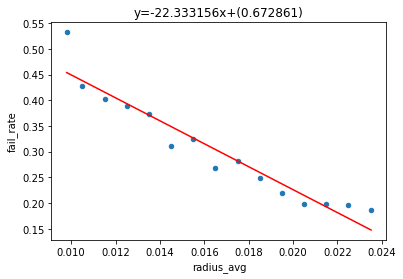

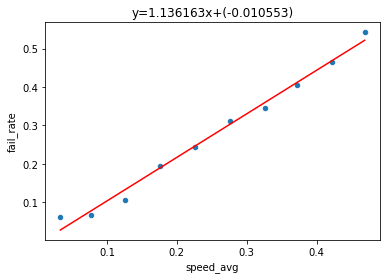

radius( 0.009 ~ 0.010 ) : average: 0.0098  fail_rate: 0.5432%  completion_time_mean: 0.9417s
radius( 0.010 ~ 0.011 ) : average: 0.0105  fail_rate: 0.4639%  completion_time_mean: 0.9104s
radius( 0.011 ~ 0.012 ) : average: 0.0115  fail_rate: 0.4627%  completion_time_mean: 0.8605s
radius( 0.012 ~ 0.013 ) : average: 0.0125  fail_rate: 0.3842%  completion_time_mean: 0.8180s
radius( 0.013 ~ 0.014 ) : average: 0.0135  fail_rate: 0.3645%  completion_time_mean: 0.8309s
radius( 0.014 ~ 0.015 ) : average: 0.0145  fail_rate: 0.3223%  completion_time_mean: 0.7954s
radius( 0.015 ~ 0.016 ) : average: 0.0155  fail_rate: 0.3462%  completion_time_mean: 0.7854s
radius( 0.016 ~ 0.017 ) : average: 0.0165  fail_rate: 0.2658%  completion_time_mean: 0.7446s
radius( 0.017 ~ 0.018 ) : average: 0.0175  fail_rate: 0.2776%  completion_time_mean: 0.7478s
radius( 0.018 ~ 0.019 ) : average: 0.0185  fail_rate: 0.2496%  completion_time_mean: 0.7411s
radius( 0.019 ~ 0.020 ) : average: 0.0195  fail_rate: 0.2258%  complet

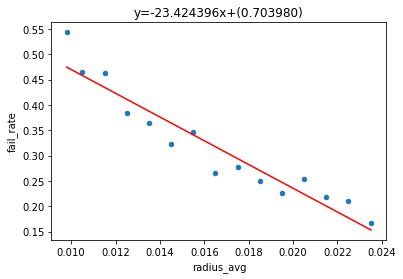

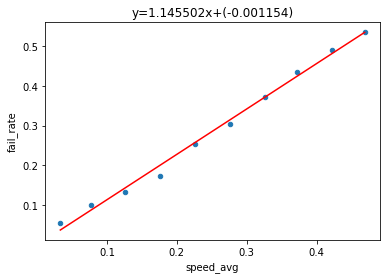

In [6]:
my_corr = extract_data(my_click_datas, True)
opponent_corr = extract_data(opponent_click_datas, True)

                       Non-Adversarial Model  Adversarial Model
Non-Adversarial Model               1.000000           0.982213
Adversarial Model                   0.982213           1.000000
                       Non-Adversarial Model  Adversarial Model
Non-Adversarial Model               1.000000           0.975795
Adversarial Model                   0.975795           1.000000


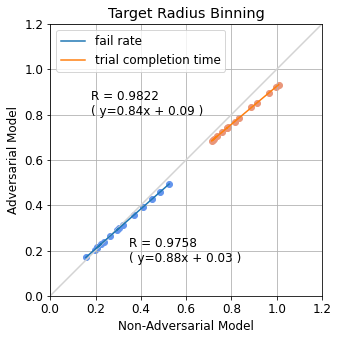

                       Non-Adversarial Model  Adversarial Model
Non-Adversarial Model               1.000000           0.969087
Adversarial Model                   0.969087           1.000000
                       Non-Adversarial Model  Adversarial Model
Non-Adversarial Model               1.000000           0.985434
Adversarial Model                   0.985434           1.000000


<Figure size 432x288 with 0 Axes>

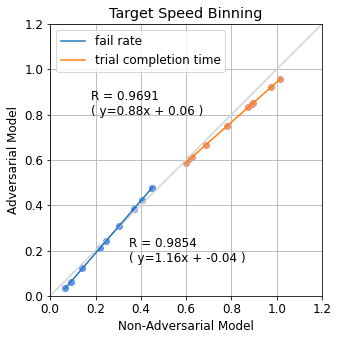

<Figure size 432x288 with 0 Axes>

In [7]:
print_corr_graph('Non-Adversarial Model', prof_corr, 'Adversarial Model', my_corr)

                       Non-Adversarial Model  Adversarial Model
Non-Adversarial Model               1.000000           0.981102
Adversarial Model                   0.981102           1.000000
                       Non-Adversarial Model  Adversarial Model
Non-Adversarial Model               1.000000           0.977514
Adversarial Model                   0.977514           1.000000


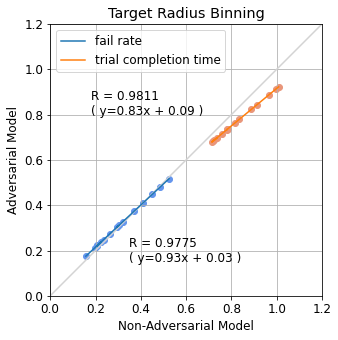

                       Non-Adversarial Model  Adversarial Model
Non-Adversarial Model               1.000000           0.942285
Adversarial Model                   0.942285           1.000000
                       Non-Adversarial Model  Adversarial Model
Non-Adversarial Model               1.000000           0.988268
Adversarial Model                   0.988268           1.000000


<Figure size 432x288 with 0 Axes>

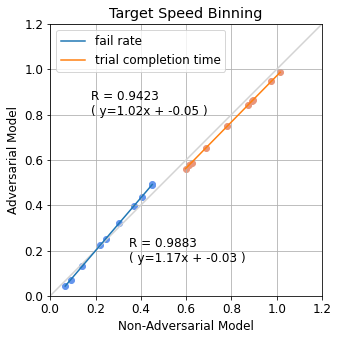

<Figure size 432x288 with 0 Axes>

In [8]:
print_corr_graph('Non-Adversarial Model', prof_corr, 'Adversarial Model', opponent_corr)

                     Adversarial Model-1  Adversarial Model-2
Adversarial Model-1             1.000000             0.989208
Adversarial Model-2             0.989208             1.000000
                     Adversarial Model-1  Adversarial Model-2
Adversarial Model-1             1.000000             0.978044
Adversarial Model-2             0.978044             1.000000


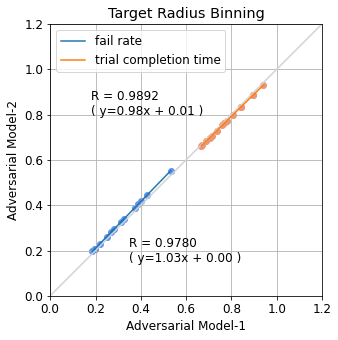

                     Adversarial Model-1  Adversarial Model-2
Adversarial Model-1             1.000000             0.979331
Adversarial Model-2             0.979331             1.000000
                     Adversarial Model-1  Adversarial Model-2
Adversarial Model-1             1.000000             0.993331
Adversarial Model-2             0.993331             1.000000


<Figure size 432x288 with 0 Axes>

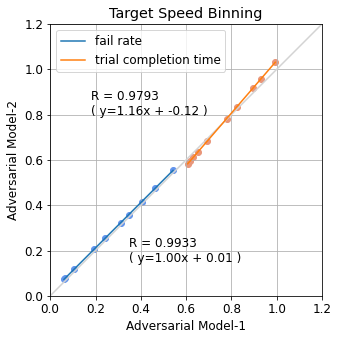

<Figure size 432x288 with 0 Axes>

In [9]:
print_corr_graph('Adversarial Model-1', my_corr, 'Adversarial Model-2', opponent_corr)

radius( 0.009 ~ 0.010 ) : average: 0.0098  fail_rate: 0.5490%  completion_time_mean: 0.8992s
radius( 0.010 ~ 0.011 ) : average: 0.0105  fail_rate: 0.4634%  completion_time_mean: 0.8810s
radius( 0.011 ~ 0.012 ) : average: 0.0115  fail_rate: 0.4766%  completion_time_mean: 0.8587s
radius( 0.012 ~ 0.013 ) : average: 0.0125  fail_rate: 0.4204%  completion_time_mean: 0.8339s
radius( 0.013 ~ 0.014 ) : average: 0.0135  fail_rate: 0.3625%  completion_time_mean: 0.8174s
radius( 0.014 ~ 0.015 ) : average: 0.0145  fail_rate: 0.3308%  completion_time_mean: 0.7874s
radius( 0.015 ~ 0.016 ) : average: 0.0155  fail_rate: 0.3198%  completion_time_mean: 0.7753s
radius( 0.016 ~ 0.017 ) : average: 0.0165  fail_rate: 0.3054%  completion_time_mean: 0.7526s
radius( 0.017 ~ 0.018 ) : average: 0.0175  fail_rate: 0.2638%  completion_time_mean: 0.7231s
radius( 0.018 ~ 0.019 ) : average: 0.0185  fail_rate: 0.2699%  completion_time_mean: 0.7254s
radius( 0.019 ~ 0.020 ) : average: 0.0195  fail_rate: 0.2408%  complet

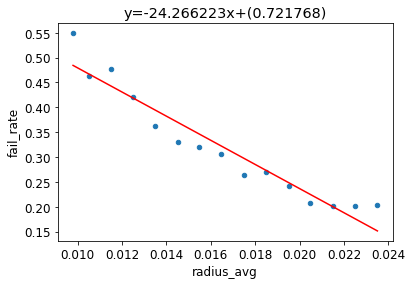

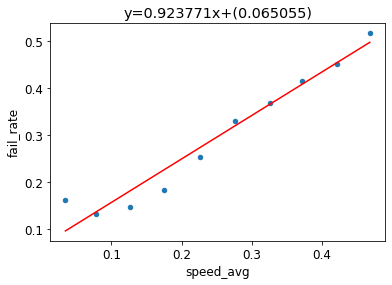

radius( 0.009 ~ 0.010 ) : average: 0.0098  fail_rate: 0.6399%  completion_time_mean: 1.0060s
radius( 0.010 ~ 0.011 ) : average: 0.0105  fail_rate: 0.6030%  completion_time_mean: 1.0155s
radius( 0.011 ~ 0.012 ) : average: 0.0115  fail_rate: 0.6102%  completion_time_mean: 0.9927s
radius( 0.012 ~ 0.013 ) : average: 0.0125  fail_rate: 0.5650%  completion_time_mean: 0.9146s
radius( 0.013 ~ 0.014 ) : average: 0.0135  fail_rate: 0.5000%  completion_time_mean: 0.8944s
radius( 0.014 ~ 0.015 ) : average: 0.0145  fail_rate: 0.4710%  completion_time_mean: 0.8672s
radius( 0.015 ~ 0.016 ) : average: 0.0155  fail_rate: 0.4666%  completion_time_mean: 0.8343s
radius( 0.016 ~ 0.017 ) : average: 0.0165  fail_rate: 0.4714%  completion_time_mean: 0.7907s
radius( 0.017 ~ 0.018 ) : average: 0.0175  fail_rate: 0.3850%  completion_time_mean: 0.7470s
radius( 0.018 ~ 0.019 ) : average: 0.0185  fail_rate: 0.3906%  completion_time_mean: 0.7262s
radius( 0.019 ~ 0.020 ) : average: 0.0195  fail_rate: 0.3737%  complet

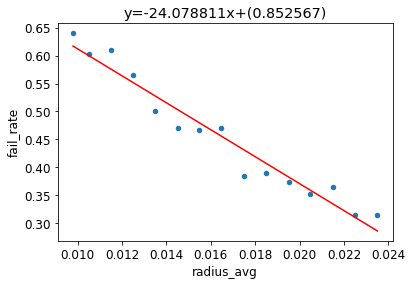

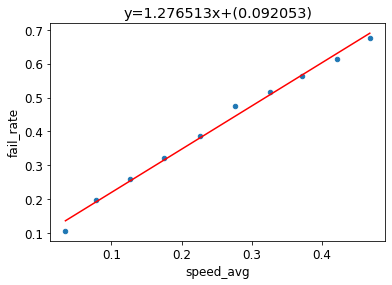

In [10]:
improved_decision_making_corr = extract_data(improved_decision_making_datas, True)
improved_motor_execution_corr = extract_data(improved_motor_execution_datas, True)

                                      Improved Decision-Making Skill Agent  \
Improved Decision-Making Skill Agent                               1.00000   
Improved Motor Execution Agent                                     0.99132   

                                      Improved Motor Execution Agent  
Improved Decision-Making Skill Agent                         0.99132  
Improved Motor Execution Agent                               1.00000  
                                      Improved Decision-Making Skill Agent  \
Improved Decision-Making Skill Agent                              1.000000   
Improved Motor Execution Agent                                    0.984089   

                                      Improved Motor Execution Agent  
Improved Decision-Making Skill Agent                        0.984089  
Improved Motor Execution Agent                              1.000000  


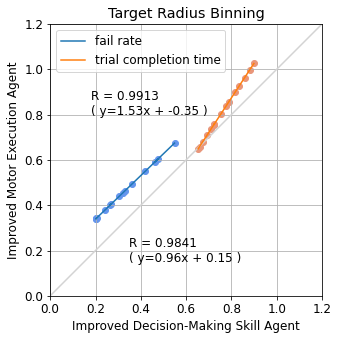

                                      Improved Decision-Making Skill Agent  \
Improved Decision-Making Skill Agent                              1.000000   
Improved Motor Execution Agent                                    0.933837   

                                      Improved Motor Execution Agent  
Improved Decision-Making Skill Agent                        0.933837  
Improved Motor Execution Agent                              1.000000  
                                      Improved Decision-Making Skill Agent  \
Improved Decision-Making Skill Agent                              1.000000   
Improved Motor Execution Agent                                    0.962022   

                                      Improved Motor Execution Agent  
Improved Decision-Making Skill Agent                        0.962022  
Improved Motor Execution Agent                              1.000000  


<Figure size 432x288 with 0 Axes>

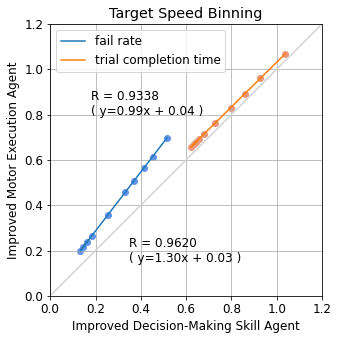

<Figure size 432x288 with 0 Axes>

In [11]:
print_corr_graph('Improved Decision-Making Skill Agent', improved_decision_making_corr, 'Improved Motor Execution Agent', improved_motor_execution_corr)